In [44]:
%matplotlib inline 
import matplotlib.pyplot as plt

import string
from os import listdir
import os
import errno
import subprocess
from collections import defaultdict
import operator
import re
import pickle
from collections import OrderedDict
import six # needed for Google Cloud client

import unidecode

import numpy as np
import pandas as pd
import scipy.sparse

from scipy.sparse.csr import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from sklearn.manifold import TSNE

import nltk

In [31]:
%load_ext autoreload
%autoreload 2

In [6]:
df = pd.read_json('ethnic_categories.json', dtype={})

In [9]:
print 'dataset size:', len(df)
df.sample(5)

dataset size: 14442


,categories,cookingTime,description,ethnicCategory,fullCategoryTree,ingredients,instructionSteps,name,rating,ratingCount,url
4294,"[Beef Meatloaf, Meatloaf, Main Dishes, Recipes...",PT1H45M,NaN,us-recipes,us-recipes,"[1 pound ground sirloin, 1 tomato, diced, 4 mu...",[Preheat an oven to 350 degrees F (175 degrees...,Habanero and Goat Cheese Meat Loaf,3.43,6,http://allrecipes.com/recipe/187799/habanero-a...
13810,"[Bean and Pea Soups, Soup, Soups, Stews and Ch...",PT1H15M,NaN,portuguese,european/portuguese,"[4 tomatoes, peeled and chopped, 1 tablespoon ...","[Combine tomatoes, butter, dried minced onion,...",Kale and Cabbage Soup,4.23,11,http://allrecipes.com/recipe/232406/kale-and-c...
5205,"[Shrimp Salad, Crab Salad, Seafood Salad, Shri...",PT4H45M,NaN,us-recipes,us-recipes,"[3 cups uncooked elbow macaroni, 5 eggs, 2 str...",[Place eggs in a saucepan and cover with cold ...,Shrimp and Crab Macaroni Salad,4.15,19,http://allrecipes.com/recipe/21664/shrimp-and-...
3596,"[Shrimp Soup, Seafood Soup, Soup, Soups, Stews...",PT1H15M,NaN,us-recipes,us-recipes,"[1/2 cup butter, 1 small onion, chopped, 1/2 b...",[Melt the butter in a large pot over medium he...,Cajun Shrimp Soup,4.75,18,http://allrecipes.com/recipe/185993/cajun-shri...
6100,"[Seafood Stew, Etouffee, Stew, Soups, Stews an...",PT45M,NaN,us-recipes,us-recipes,"[1 cup butter, 2 tablespoons all-purpose flour...","[In a stock pot, melt butter over medium heat....",Crawfish Etouffee Like Maw-Maw Used to Make,4.24,46,http://allrecipes.com/recipe/22732/crawfish-et...


In [15]:
df[['url']].values[5883]

array([u'http://allrecipes.com/recipe/26671/texas-cowboy-chili-beans/'], dtype=object)

In [14]:
#df[['ethnicCategory']].values.nunique()
df['ethnicCategory'].value_counts()

us-recipes                      3504
italian                         2420
mexican                         2112
canadian                        1030
indian                           671
australian-and-new-zealander     499
french                           440
greek                            377
chinese                          323
german                           301
thai                             227
japanese                         222
irish                            199
filipino                         147
english                          143
spanish                          120
polish                           119
korean                           117
swedish                          102
brazilian                         93
russian                           84
cuban                             81
vietnamese                        66
puerto-rican                      66
portuguese                        66
lebanese                          61
moroccan                          53
s

In [15]:
cat_mapping_lines = """argentinian  latin_american
australian-and-new-zealander  north_european
austrian  north_european
bangladeshi  south_asian
belgian  north_european
brazilian  latin_american
canadian  north_american
chilean  latin_american
chinese  east_asian
colombian  latin_american
cuban  latin_american
czech  east_european
danish  north_european
dutch  north_european
east-african  african
egyptian  african
english  north_european
filipino  southeast_asian
finnish  north_european
french  north_european
german  north_european
greek  middle_eastern
hungarian  east_european
indian  south_asian
indonesian  southeast_asian
irish  north_european
israeli  middle_eastern
italian  south_european
jamaican  latin_american
japanese  east_asian
korean  east_asian
lebanese  middle_eastern
malaysian  southeast_asian
mexican  latin_american
moroccan  african
norwegian  north_european
pakistani  south_asian
persian  middle_eastern
peruvian  latin_american
polish  east_european
portuguese  south_european
puerto-rican  latin_american
russian  east_european
scottish  north_european
south-african  african
spanish  south_european
swedish  north_european
swiss  north_european
thai  southeast_asian
turkish  middle_eastern
us-recipes  north_american
vietnamese  southeast_asian
welsh  north_european"""

#print cat_mapping_lines
cat_mapping_dict = {}
cat_mapping_list = cat_mapping_lines.split('\n')
#print cat_mapping_list

for mapping in cat_mapping_list:
    #print line
    smaller_category, larger_category = mapping.split()
    cat_mapping_dict[smaller_category] = larger_category
print cat_mapping_dict

{'australian-and-new-zealander': 'north_european', 'portuguese': 'south_european', 'irish': 'north_european', 'mexican': 'latin_american', 'chinese': 'east_asian', 'czech': 'east_european', 'scottish': 'north_european', 'east-african': 'african', 'japanese': 'east_asian', 'moroccan': 'african', 'spanish': 'south_european', 'persian': 'middle_eastern', 'polish': 'east_european', 'austrian': 'north_european', 'swedish': 'north_european', 'israeli': 'middle_eastern', 'puerto-rican': 'latin_american', 'turkish': 'middle_eastern', 'south-african': 'african', 'bangladeshi': 'south_asian', 'german': 'north_european', 'peruvian': 'latin_american', 'indian': 'south_asian', 'dutch': 'north_european', 'korean': 'east_asian', 'pakistani': 'south_asian', 'colombian': 'latin_american', 'belgian': 'north_european', 'danish': 'north_european', 'indonesian': 'southeast_asian', 'hungarian': 'east_european', 'egyptian': 'african', 'welsh': 'north_european', 'brazilian': 'latin_american', 'us-recipes': 'n

In [16]:
def consolidate_ethnic_categories(cat):
    return cat_mapping_dict[cat]
df['consolidated_category'] = df['ethnicCategory'].apply(consolidate_ethnic_categories)

In [17]:
df.groupby('consolidated_category').consolidated_category.count()

consolidated_category
african             140
east_asian          662
east_european       267
latin_american     2517
middle_eastern      555
north_american     4534
north_european     1938
south_asian         714
south_european     2606
southeast_asian     509
Name: consolidated_category, dtype: int64

In [34]:
%%writefile cleaning_util.py


import unidecode

import numpy as np
import pandas as pd

def translate_non_alphanumerics(to_translate, translate_to=u''):
    # https://stackoverflow.com/a/1324274/2491761
    not_letters = u'!"#%\'()&*+,-./:;<=>?@[\]^_`{|}~0123456789'
    if isinstance(to_translate, unicode):
        #print "unicode instance"
        translate_table = dict((ord(char), unicode(translate_to)) for char in not_letters)
    else:
        #print "not unicode instance"
        assert isinstance(to_translate, str)
        #translate_table = string.maketrans(not_letters, translate_to *len(not_letters))
        return to_translate.translate(None, string.punctuation + string.digits)
    return to_translate.translate(translate_table)

def extract_ingredients(full_ingred_list, strip_punct=True):
    # From: https://en.wikibooks.org/wiki/Cookbook:Units_of_measurement
    meas_units = [
        'teaspoon', 'teaspoons',
        't',
        'tsp', 'tsps',
        'tablespoon','tablespoons',
        'tbl',
        'tbs',
        'tbsp', 'tbsps',
        'fl', 'fluid',
        'oz', 'ozs',
        'ounce', 'ounces',
        'cup', 'cups',
        'c',
        'pint', 'pints',
        'p',
        'pt',
        'quart', 'quarts',
        'qt', 'qts',
        'q', 'qs',
        'gallon', 'gallons',
        'gal', 'gals',
        'jiggers', 'jigger',
        'ml',
        'milliliter', 'milliliters',
        'millilitre', 'millilitres',
        'cc',
        'l',
        'liter', 'liters',
        'litre', 'litres',
        'pinch', 'pinches',        
        'pound', 'pounds',
        'lb', 'lbs',
        'mg', 'mgs',
        'milligram', 'milligrams',
        'milligramme', 'milligrammes',
        'g', 'gs',
        'gram', 'grams',
        'gramme', 'grammes',
        'kg', 'kgs',
        'kilogram', 'kilograms',
        'kilogramme', 'kilogrammes',
        'mm', 'mms',
        'millimeter', 'millimeters',
        'millimetre', 'millimetres',
        'cm', 'cms',
        'centimeter', 'centimeters',
        'centimetre', 'centimetres',
        'm', 'ms',
        'meter', 'meters',
        'metre', 'metres',
        'inch', 'inches',
        'in', 'ins',
        ###
        'loaf', 'loaves',
        'pouch', 'pouches',
        'wedge', 'wedges',
        'drop', 'drops',
        'amount', 'amounts',
        'bulk', 'bulks',
        'coating', 'coatings',
        'carton', 'cartons',
        'count',
        'dusting', 'dustings',
        'roll', 'rolls',
        'hint', 'hints',
        'round', 'rounds',
        'cube', 'cubes',
        'husk', 'husks',
        'envelope', 'envelopes',
        'container', 'containers',
        'dash', 'dashes',
        'bitesize', 'bitesized',
        'bite', 'sized',
        'size',
        'each',
        'taste', 'desired',
        'can', 'cans',
        'unit', 'units',
        'box', 'boxes',
        'tub', 'tubs',
        'slab', 'slabs',
        'sprig', 'sprigs',
        'stalk', 'stalks',
        'matchstick', 'matchsticks',
        'balls',
        'clove', 'cloves',
        'slice', 'slices',
        'head', 'heads',
        'spear', 'spears',
        'chunk', 'chunks',
        'piece', 'pieces',
        'jar', 'jars',
        'package', 'packages',
        'pack', 'packs',
        'packet', 'packets',
        'bunch', 'bunches',
        'tube', 'tubes',
        'jug', 'jugs',
        'bottle', 'bottles',
        'stick', 'sticks',
        'strip', 'strips',
        'bag', 'bags',
        'dash', 'dashes',
        'container', 'containers',
        'envelope', 'envelopes',
        'sleeve', 'sleeves',
        'rounds',
        'sheet', 'sheets',
        'squares',
        'semicircles', 'semicircle',
        'circles', 'circle',
        'moons', 'halfmoons',
        'strands', 'strands',
        'ribbons', 'ribbon',
        'whole',
        'extra', 'extras',
        'dozen', 'dozens',
        'half', 'halves',
        'third', 'thirds',
        'fourth', 'fourths',
        'quarter', 'quarters',
        'fifth', 'fifths',
        'eighth', 'eighths',
    ]
    
    preparatory_descriptions = [
        'baked',
        'beat', 'beaten', 'wellbeaten',
        'blanched',
        'blended',
        'boiled',
        'bottled',
        'broiled',
        'broken',
        'browned',
        'canned',
        'chilled',
        'chipped',
        'chopped',
        'cleaned',
        'converted',
        'cooked',
        'cooled',
        'cored',
        'crispcooked',
        'crumbled',
        'crushed',
        'cubed',
        'cut',
        'defrosted',
        'deshelled',
        'desilked',
        'deveined',
        'diced', 'dice',
        'dissolved',
        'divided',
        'drained',
        'dried',
        'filleted',
        'filtered',
        'flaked',
        'fresh',
        'fried',
        'frozen',
        'grated',
        'grilled',
        'ground',
        'halved',
        'hardened',
        'heated',
        'hulled',
        'husked',
        'individual',
        'jarred',
        'juiced',
        'julienned', 'julienne', 'juliennecut', 'juliennesliced',
        'kneaded', 'kneading',
        'marinated',
        'mashed',
        'matchstickcut',
        'melted',
        'microwaved',
        'minced',
        'mixed',
        'opened',
        'packed',
        'peeled',
        'pitted',
        'pounded',
        'prepared',
        'pressed',
        'prewashed',
        'processed',
        'pulled',
        'quartered',
        'raw',
        'refrigerated',
        'removed',
        'rinsed',
        'ripe',
        'ripened',
        'ripped',
        'roasted',
        'rolled', 'rolling',
        'salted',
        'saved',
        'scored',
        'scrubbed',
        'seasoned',
        'sectioned',
        'seeded',
        'separated',
        'shaved',
        'shelled',
        'shredded',
        'shucked',
        'sifted',
        'smashed',
        'smoked',
        'snipped',
        'sliced',
        'slivered',
        'softened',
        'split',
        'squeezed',
        'steamed',
        'stemmed',
        'strained',
        'soaked',
        'sweetened',
        'thawed',
        'toasted',
        'torn',
        'trimmed',
        'uncored',
        'uncooked',
        'undrained',
        'unhusked',
        'unopened',
        'unpeeled',
        'unsalted',
        'unsweetened',
        'unwashed',
        'unwrapped',
        'use', 'used',
        'warmed',
        'washed',
        'wrapped',
        'zested',
    ]
    
    other_words_to_filter = [
        # articles:
        'a', 'an', 'the',
        # adverbs:
        'accordingly', 'according',
        'all',
        'approximately',
        'artificially ',
        'coarsely',
        'crisply',
        'crosswise',
        'diagonally', 
        'finely',
        'freshly',
        'horizontally',
        'left',
        'lengthwise', 
        'lightly',
        'like',
        'moreorless ',
        'nearly',
        'overnight',
        'piecewise',
        'plus',
        'right',
        'roughly',
        'sideways',
        'slightly',
        'stiffly',
        'then',
        'thickly',
        'thinly',
        'vertically',
        'very',
        'well',
        'widthwise', 
        # adjectives:
        'additional ',
        'aged',
        'allpurpose',
        'another',
        'any',
        'best',
        'certified',
        'chunky',
        'classic',
        'coarse', 
        'cold',
        'complete',
        'crisp',
        'diagonal',
        'discarded',
        'dry',
        'extralarge',
        'extrasmall', 
        'even',
        'fatfree',
        'favourite', 'favorite',
        'fine', 
        'firm',
        'flat',
        'fresh',
        'hard',
        'hot',
        'inchesthick', 'inchthick',
        'included',
        'inner',
        'jumbo',
        'large', 
        'lean',
        'leftover',
        'less',
        'long',
        'lowcalorie',
        'lowfat',
        'lowsodium',
        'matchsticksize',
        'medium',
        'moist',
        'more',
        'multicolored',
        'natural',
        'needed',
        'new',
        'nonfat',
        'old',
        'oldfashioned',
        'only',
        'optional',
        'organic',
        'original',
        'other',
        'outer',
        'pure',
        'real',
        'reduced',
        'reserved',
        'rough',
        'sharp',
        'short',
        'small',
        'stale',
        'soft',
        'such',
        'supreme',
        'thick',
        'thickcut',
        'thicklycut',
        'thicklysliced',
        'thicksliced',
        'thin',
        'thincut',
        'thinlycut',
        'thinlysliced',
        'thinsliced',
        'tough',
        'young',
        'your',
        # prepositions:
        'about',
        'above',
        'across',
        'against',
        'apart',
        'as',
        'at',
        'away',
        'below',
        'by',
        'for',
        'from',
        'in',
        'into',
        'of',
        'off',
        'on',
        'out',
        'to',
        'until',
        'with',
        'without',
        # conjunctions:
        'and',
        'but',
        'if',
        'or',
        'so',
        # abbreviations:
        'eg', 'ie',
        # nouns:
        'accompaniments',
        'blossoms',
        'bottoms', 'bottom',
        'choice',
        'directions',
        'ends', 'end',
        'fists', 'fist',
        'hands', 'hand',
        'hours', 'hour',
        'ingredients',
        'list',
        'minutes', 'minute',
        'slicer',
        'peeler',
        'product',
        'purpose',
        'reserve',
        'room',
        'seconds', 'second',
        'spirals', 'spiral',
        'temperature',
        'thickness',
        'thinness',
        'tops', 'top',
        # verbs:
        'add',
        'alternating',
        'are',
        'be',
        'discarding',
        'including',
        'is',
        'sit',
        'using',
    ]
    
    #print "Before..."
    #print full_ingred_list
    
    # strip punctuation chars
    # all lowercase
    if strip_punct:
        cleaned_ingred_list = [translate_non_alphanumerics(s).lower() for s in full_ingred_list]
    else:
        cleaned_ingred_list = full_ingred_list
    
    #print "length of cleaned_ingred_list: {}".format(len(cleaned_ingred_list))
    #print cleaned_ingred_list
    if len(cleaned_ingred_list) == 0:
        print "length of cleaned_ingred_list is zero"
        print "full_ingred_list:"
        print full_ingred_list
    
    # split on whitespace
    # throw out meas units
    #print
    #print "After..."
    if isinstance(cleaned_ingred_list[0], unicode):
        ingreds_only = [' '.join(w for w in unidecode.unidecode(ingred_item).split() if w not in meas_units and w not in preparatory_descriptions and w not in other_words_to_filter)
             for ingred_item in cleaned_ingred_list
             ]
    else:
        assert isinstance(cleaned_ingred_list[0], str)
        ingreds_only = [' '.join(w for w in ingred_item.split() if w not in meas_units and w not in preparatory_descriptions and w not in other_words_to_filter)
             for ingred_item in cleaned_ingred_list
             ]
    ingreds_only = filter(None, ingreds_only) # remove empty strings at end
    #print ingreds_only
    
    brand_names = [
        'a(r)', # A1 steak sauce
        'absolut(r)',
        'accents(r)', 'accents(tm)', 'accent(r)',
        'act ii(r)',
        'adams(r)',
        'al fresco(r)',
        'amafil(r)',
        'annies lemon chive dressing(r)',
        'archer farms(tm)',
        'arrowhead mills(r)',
        'artisan blends(r)',
        'aylmer(r) accents(r)',
        'babybel(r)',
        'bacardi (r)', 'bacardi(r)',
        'backdraft fire sauce(r)',
        'ball(r) kerr(r)',
        'ball park(r)',
        'barilla(r)',
        'barill pronto(tm)',
        'bay(r)', 'bay (tm)',
        'beau monde (tm)',
        'beechers(r) flagship', 'beechers flagship', 'beechers(r)',
        'beer shiner(r)',
        'belgioioso',
        'benedictine(r)',
        'bertolli(r)',
        'best foods(r)',
        'better than bouillon(r)',
        'betty crocker(r)',
        'birds eye(r)',
        'bisquick(r)',
        'bisquick (r)',
        'bobs red mill(r)',
        'borden(r)',
        'bragg(r)',
        'breeze(r)',
        'briannas home style(r)', 'briannas(r)',
        'brooks(r)',
        'bruces(r)',
        'budweiser(r)',
        'buitoni(r)',
        'bullseye(r)',
        'bumble bee(r)',
        'burnetts(r)',
        'bushs best(r)', 'bushs homestyle(r)', 'bushs chili magic(r)', 'bushs(r)',
        'butterball(r)',
        'butter buds(r)',
        'campari(r)',
        'campbells(r) healthy request', 'campbells(r)', 'campbells (r)',
        'carnation (r)',
        'carolina pride(r)',
        'carroll shelbys(r)',
        'cascadian farm(r)',
        'catelli bistro(r)',
        'cattlemens(r)',
        'cavenders(r)',
        'chambord(r)',
        'chef paul prudhommes salmon magic(r)',
        'cheese whiz(r)', 'cheez whiz(r)',
        'chobani(r)',
        'cholula(r)',
        'ciroc(r)',
        'clamato(r)',
        'classicmac(tm)',
        'classico (tm)',
        'classico (r)',
        'classico(r)',
        'claussen(r)',
        'coke(r)',
        'cointreau(r)',
        'college inn(r)',
        'contadina(r)',
        'cool whip(r)',
        'coors(r)',
        'cornnuts (r)',
        'corona(r)',
        'cortland',
        'country time(r)',
        'craisins(r)',
        'crazy steves(tm) cajun cukes', 'crazy steves(r)',
        'cremovo(r)',
        'crisco(r)',
        'daisy(r)',
        'dei fratelli(r)',
        'del monte(r)',
        'diamond crystal(r)',
        'dickinsons(r)',
        'dole(r)',
        'dole asian island crunch(tm)',
        'dole(r) veggie(tm)',
        'doritos(r)',
        'dubliner(r)',
        'dukes(r)',
        'duncan hines(r)',
        'durkee(r)', 'famous sauce(r)',
        'eagle brand(r)',
        'earth balance(r)',
        'eckrich(r)',
        'edward sons(r)',
        'egg beaters(r)',
        'el paso(r) ',
        'el pato(r)',
        'embasa(r)',
        'emerald(r)',
        'equal(r)',
        'farmland(r)',
        'fat tire(r)',
        'fiesta blend(r)',
        'fleischmanns(r)', 'fleischmanns ',
        'folgers(r)',
        'follow your heart(r) veganaise(r)', 'follow your heart(r)',
        'fosters (r)',
        'foster farms(r)',
        'franks(r) redhot', 'franks red hot (r)', 'franks redhot (r)', 'franks redhot(r)', 'redhot(r)', 'franks(r)',
        'frenchs(r)',
        'frichik(r)',
        'fritos(r)',
        'frontera(r)',
        'goya (r)', 'goya(r)',
        'gebhardt(r)',
        'ghirardelli(r)',
        'girards(r) olde venice',
        'good seasons(r)',
        'goodness(r)',
        'gourmet garden(tm)',
        'grapenuts(tm)',
        'great american spice co(tm)',
        'green giant(r)', 'green giant(tm) crumbles(r)', 'green giant(tm)',
        'grill mates(r)',
        'guinness(r)',
        'hangar one(r)',
        'harp(r)',
        'hatch(r)',
        'healthy choice(r)',
        'heineken(r)', 
        'heinz (r)', 'heinz(r)',
        "hellmann's(r) best foods(r)", 'hellmanns(r) best foods(r)', 'hellmanns(r)best foods(r)',
        'hellmanns light(r)', 'hellmans(r) light', 'hellmanns(r) low fat',
        'hellmans(r)', "hellmann's(r)", 'hellmanns(r)',
        'hershey(r)s', 'hershey(r)s kisses(r)', 'hersheys(r) chipits(r)', 'hersheys(r)',
        'hidden valley ranch(r)', 'hidden valley(r) original ranch(r)', 'hidden valley(r) ranch(r)', 'hidden valley(r)', 'hidden valley (r)',
        'hillshire farm(r)',
        'holland house(r)',
        'horizon(r)',
        'hormel(r)', 'hormel(tm)',
        'house tsang(r)',
        'hunts(r)',
        'idahoan(r)','baby reds(r)', 'buttery homestyle(r)',
        'imagine(r)', 'imagine(tm)',
        'isalys(r)',
        'jack daniels(r)',
        'jello(r)',
        'jennieo(r)',
        'jif(r)',
        'jiffy(r)',
        'jim beam(r)',
        'jimmy dean(r)',
        'johnsonville(r)',
        'johnnys seasoning salt(r)',
        'jose cuervo(r)', 'cuervo(r)',
        'kame(r)',
        'karo(r)',
        'karys(r)',
        'kc masterpiece(r)',
        'keebler club(r)', 'keebler(r)',
        'keens(r)',
        'kens steak house(r)',
        'kens steak house lite northern italian dressing(r)',
        'kerrygold(r)',
        'kewpie(r)',
        'kikkoman(r)',
        'king arthur(r)',
        'king oscar(r)',
        'kirkland(r)',
        'kitchen basics(r)',
        'kitchen bouquet(r)',
        'kitchen secrets(r)',
        'klondike gourmet(r)', 'klondike goldust(r)', 'klondike(r)',
        'knorr(r) rice sides(tm)', 'knorr(r) fiesta sides(tm)', 'knorr(r)', 'knorrs(r)',
        'knox (r)',
        'kraft(r)',
        'land o lakes(r)', 'land olakes(r)',
        'laphroiag(r)',
        'laughing cow(r)',
        'lawrys(r)',
        'libbys(r)',
        'lightlife(r) organic smoky tempeh strips(r)', 'lightlife(r)',
        'lipton(r) recipe secrets(r)', 'lipton(r)',
        'locatelli(r)',
        'loma linda(r)',
        'lotus(r)',
        'louisiana(r)',
        'maggi(r)',
        'magic(r)',
        'mahatma(r)',
        'maifun(r)',
        'maille(r)',
        'maldon(r)',
        'malibu(r)',
        'marie callenders(r)',
        'maries(r)',
        'market pantry(tm)',
        'martha white(r)',
        'mary kitchen(r)',
        'marzettis(r)',
        'maui(r)',
        'mazola(r)',
        'mccormick chili seasoning mix sodium(r)', 'mccormick(r)',
        'mexene(r)',
        'mexenes(r)',
        'mexicorn(r)',
        'miller lite(r)',
        'mimiccreme(r)',
        'minute(r)',
        'miracle whip(r)',
        'miracle whip(tm)',
        'miracle whip (tm)',
        'miracle whip free(r)',
        'miracle whip light(r)', 'light miracle whip(r)',
        'mission(r)',
        'montreal steak seasoning(r)',
        'morningstar farms(r) grillers recipe crumbles(r)', 'morningstar farms(r) recipe crumbles(r)', 'morningstar farms(r)',
        'morton(r) natures seasons(r)', 'mortons(r)', 'morton(r)',
        'motts(r)',
        'mountain dew(r)',
        'mrs butterworths(r)',
        'mrs dash(r)',
        'muir glen(r)',
        'nabisco(r)',
        'natural goodness(tm)',
        'negra modelo(r)',
        'nescafe(r)',
        'nestle(r) toll house(r)', 'nestle(r) carnation(r)', 'nestle(r)',
        'newcastle(r)',
        'newmans own(r)',
        'newmans own(r) lighten up(r)', 'lighten up(r)',
        'niblets(r)',
        'nissin(r) top ramen',
        'no yolks(r)',
        'ocean spray(r)',
        'oikos(r)',
        'old bay(r)', 'old bay (tm)', 'old bay(tm)',
        'old el paso(r)',
        'olive garden(r)',
        'oreida(r) steam n mash(r)', 'oreida(r)', 'ore ida(r)',
        'oreo(r)',
        'ortega(r)',
        'ottogi ramyonsari(r)', 'ottogi(r)',
        'pace(r)',
        'pam(r)',
        'parkay(r)',
        'pataks(r)',
        'penzeys(r)', 'penzys(r)',
        'pepperidge farm(r)',
        'perdue(r)',
        'pernod(r)',
        'perrins(r)',
        'pet(r)',
        'pillsbury grands(r)', 'pillsbury(r) grands(r)', 'pillsbury(r)',
        'planters(r)',
        'plochmans(r)',
        'prego(r)',
        'progresso(tm) recipe starters(tm)', 'progresso(r)',
        'quaker(r)',        
        'quorn(tm)',
        'ragu(r) old world style(r)', 'ragu(r)',
        'rapunzel(r)',
        'ready rice(r)',
        'realime(r)',
        'red gold(r)',
        'reddiwip(r)',
        'reeses(r)',
        'renees(r)',
        'reynolds wrap(r)', 'reynolds(r)',
        'rice sides(tm)',
        'ronzoni(r)',
        'rotel(r)',
        'rumford(r)',
        'saco(r)',
        'sambazon',
        'samuel smith(r)',
        'sargento(r)', 'sargento (r)',
        'sason accent(r)',
        'sb(r) golden curry', 'sb(r)',
        'seagrams(r)',
        'seasonall(r)',
        'shiner bock(r)',
        'silk(r)',
        'simple crisp(tm)',
        'simply balanced(tm)',
        'simply potatoes(r)',
        'skippy(r)',
        'skyline chili(r)',
        'slap ya mama(r)',
        'smart balance(r)',
        'smirnoff(r)',
        'smithfield(r)',
        'smuckers(r)',
        'snack factory(r)',
        'snickers(r)',
        'so delicious(r)',
        'southern comfort (r)',
        #'spam(r)',
        'spectrum naturals(r)', 'spectrum(r)',
        'spice islands(r)',
        'spike(r)',
        'splenda(r)',
        'sprite(r)',
        'sriracha(r)',
        'steam whistle pilsner(r)',
        'stovetop(r)',
        'sunmaid(r)',
        'sunsweet(r) dnoir(tm)',
        'sutton dodge(tm)',
        'swanson(r) vegetable flavor boost(r)', 'swanson(r)', 'natural goodness(r)',
        'sweet baby rays(r)',
        'sweetn low(r)',
        'tabasco(r)', 'tabasco(tm)',
        'taco bell(r)',
        'tajin(r)',
        'tapatio(r)',
        'tater tots(r)',
        'tenderflake(r)',
        'texas pete(r)', 'texas petess(r)',
        'thai kitchen(r)',
        'three bridges(r)',
        'tillamook(r)',
        'tony chacheres(r)',
        'top ramen(r)',
        'tostitos(r)',
        'trader joes(r)',
        'truroots(r)',
        'truvia(r)',
        'tyson(r) ready(r)', 'tyson(r)',
        'uncle bens (r)', 'uncle bens(r)',
        'up(r)', # 7-up
        'v(r)', # what remains from "V8"
        'valentina(r)',
        'vegenaise(r)',
        'veggie(tm)',
        #'velveeta(r)',
        'vernors(r)',
        'vidalia(r)',
        'vietti(r)',
        'vindaloo sauce maya kaimal(r)', 'vindaloo(r)',
        'voskos(r)',
        'watkins(r)',
        'wesson(r)',
        'white lily(r)',
        'wishbone(r)',
        'wolf brand (r)', 'wolf(r)',
        'wondra(r)',
        'yoplait(r)',
        'yuengling(r)',
        'yves veggie cuisine(r)',
        'zatarains(r)',
        'zing zang(r)',
    ]
    
    def remove_brands(ingred_str):
        str_without_brand = ingred_str
        for bn in brand_names:
            str_without_brand = str_without_brand.replace(bn, '')
        return str_without_brand
    
    ingreds_without_brands = [' '.join(remove_brands(ingred_str).strip().split()) for ingred_str in ingreds_only]
    
    def remove_duplicate_words(ingred_str):
        ingred_words = ingred_str.split()
        no_dupes_ingred_str = " ".join(sorted(set(ingred_words), key=ingred_words.index))
        return no_dupes_ingred_str
    
    ingreds_duplicates_removed = [remove_duplicate_words(ingred_str) for ingred_str in ingreds_without_brands]
    
    return ingreds_duplicates_removed


Overwriting cleaning_util.py


In [32]:
from cleaning_util import extract_ingredients, translate_non_alphanumerics

In [35]:
df['cleanedIngredients']=df['ingredients'].map(extract_ingredients)

In [38]:
df[['cleanedIngredients','consolidated_category']].sample(5)

,cleanedIngredients,consolidated_category
1982,"[skinless boneless chicken breast, salt pepper...",east_asian
2959,"[boneless skinless chicken breasts, mazol corn...",latin_american
1404,"[rice noodles, chicken, shrimp, eggs, carrot, ...",southeast_asian
9498,"[flour, brown sugar, eggs, butter, vanilla ext...",north_european
12940,"[spinach, curd cottage cheese, parmesan cheese...",middle_eastern


# EDA: Word to Vec Model 

Word to vec using gensim: https://radimrehurek.com/gensim/models/word2vec.html  
Here we are creating the word vectors from the list of clean ingredients. We use the Gensim model to create the similarity matrix(cosine similarity)


In [40]:
from gensim.models.word2vec import Word2Vec

print('Training a Word2vec model...')
w2v_model = Word2Vec(df['cleanedIngredients'].values, size=100, window=5, min_count=5, workers=4)

Training a Word2vec model...


In [41]:
w2v_model.wv.most_similar(positive=['onion'])

[('chicken broth', 0.9848343133926392),
 ('cabbage', 0.9767434597015381),
 ('carrot', 0.9760092496871948),
 ('green bell pepper', 0.9748931527137756),
 ('bacon', 0.9736570119857788),
 ('stewed tomatoes', 0.9720339775085449),
 ('onions', 0.9711138010025024),
 ('mushrooms', 0.9702577590942383),
 ('tomatoes', 0.9695011377334595),
 ('celery', 0.9689230918884277)]

In [42]:
w2v_model.wv.most_similar(positive=['chicken'], negative=['eggs'])

[('green bell pepper', 0.8279126286506653),
 ('red bell pepper', 0.8240588903427124),
 ('tomatoes', 0.8163726925849915),
 ('black beans', 0.7828199863433838),
 ('jalapeno pepper', 0.7799763083457947),
 ('garlic', 0.7799626588821411),
 ('jalapeno peppers', 0.7714133262634277),
 ('olive oil', 0.7609297037124634),
 ('tomato paste', 0.7536452412605286),
 ('yellow bell pepper', 0.7512987852096558)]

In [45]:
X = w2v_model[w2v_model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

vocab = list(w2v_model.wv.vocab)
df_tsne = pd.concat([pd.DataFrame(X_tsne),
                pd.Series(vocab)],
               axis=1)
df_tsne.columns = ['x', 'y', 'ingredient']
df_tsne.sample(5)

,x,y,ingredient
556,3.544617,-4.892606,peach schnapps
767,14.577518,-5.505323,balsamic vinegar
1071,0.762659,9.803588,oysters liquid
926,-2.091048,-14.684964,plain bread crumbs
750,4.713042,6.145893,allspice berries


In [46]:
def showTSNEGraphForWord(w2v_model, df, pos_words = [], neg_words = []):
    vec = w2v_model.wv.most_similar(positive=pos_words, negative = neg_words)
    ingredients = [w[0] for w in vec]
    vec_df = df[df['ingredient'].isin(ingredients)]
    print vec_df
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for i, txt in enumerate(vec_df['ingredient']):
        ax.annotate(txt, (vec_df['x'].iloc[i], vec_df['y'].iloc[i]))

    ax.scatter(vec_df['x'], vec_df['y'])   

              x         y         ingredient
25    15.984874 -4.701961              bacon
472   13.338079 -8.046660  green bell pepper
1105  15.692374 -5.830408      chicken broth
1183  15.266014 -4.939347    stewed tomatoes
1331  14.198139 -7.432110             celery
1352  14.102890 -7.218480             carrot
1354  15.973111 -6.232335             onions
1370  15.858578 -5.271675            cabbage
1399  13.937926 -7.070539          mushrooms
1573  13.624085 -8.045944           tomatoes


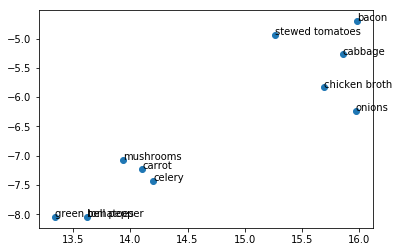

In [47]:
showTSNEGraphForWord(w2v_model, df_tsne, pos_words=['onion']) 

              x         y            ingredient
198   -0.262124  4.662649  mexican blend cheese
339   16.590653  0.419951                chives
354    9.945289  6.431077            taco sauce
497   16.962566 -1.937855  mexican cheese blend
1006  14.392073  1.067791           chili beans
1046   9.811213  6.112681     mexicanstyle corn
1096  16.478206 -0.536115      provolone cheese
1153 -13.022018 -6.163358            corn chips
1160  -0.538578  4.322235        fat sour cream
1603  16.769643 -0.973356       romaine lettuce


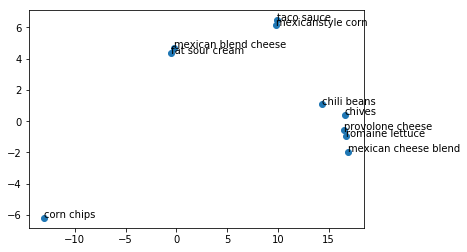

In [48]:
showTSNEGraphForWord(w2v_model, df_tsne, pos_words=['chicken', 'rice'], neg_words=['onions']) 

# POS Tagging

In [56]:
import re

sentence = "I want 2 blarhg @#$"
re.sub('[^a-zA-Z]', ' ', sentence)

'I want   blarhg    '

In [57]:
def extractVerbs(row):
    instructions = row['instructionSteps']
    tokens = []
    for inst in instructions:
        inst = re.sub('[^a-zA-Z]', ' ', inst.lower())
        tokens += inst.split()
    lstTags = nltk.pos_tag(tokens)
    verbs = []
    for item in lstTags:
        if item[1] == 'VB':
            verbs.append(item[0])
    return set(verbs)
df_verbs = df.copy()
df_verbs['verbs'] = df_verbs.apply(extractVerbs, axis=1)

In [58]:
print df_verbs['verbs'].sample(5)

221             {medium, onion, turn, add, continue, cool}
3137                     {let, add, steep, allow, combine}
6408                    {be, f, cover, quart, touch, stir}
10818    {pink, thicken, c, set, f, sear, heat, cook, p...
14203                    {taste, hold, cut, add, dissolve}
Name: verbs, dtype: object


In [59]:
def combineIngredientActions(row):
    return row['cleanedIngredients'] + list(row['verbs'])
df_verbs['combined_action_ingredients'] = df_verbs.apply(combineIngredientActions, axis=1)
print('Training a Word2vec model for ingredients + actions...')
action_ingredients_w2v_model = Word2Vec(df_verbs['combined_action_ingredients'].values, size=100, window=5, \
                                        min_count=5, workers=4)

Training a Word2vec model for ingredients + actions...


In [61]:
action_ingredients_w2v_model.wv.most_similar(positive=['chop'])

[(u'increase', 0.996721625328064),
 (u'sear', 0.9965178966522217),
 (u'pulse', 0.995469868183136),
 (u'roast', 0.9942433834075928),
 (u'penetrate', 0.9938971996307373),
 (u'tamarind', 0.9935441613197327),
 (u'tender', 0.99335777759552),
 (u'flake', 0.9927678108215332),
 (u'pop', 0.9918784499168396),
 (u'bay', 0.9916343688964844)]

In [62]:
X_2 = action_ingredients_w2v_model[action_ingredients_w2v_model.wv.vocab]

tsne_2 = TSNE(n_components=2)
X_tsne_2 = tsne.fit_transform(X_2)

vocab_2 = list(action_ingredients_w2v_model.wv.vocab)
df_tsne_2 = pd.concat([pd.DataFrame(X_tsne_2),
                pd.Series(vocab_2)],
               axis=1)
df_tsne_2.columns = ['x', 'y', 'ingredient']
df_tsne_2.sample(5)

,x,y,ingredient
1961,-0.226224,-4.178139,peanut butter
760,6.211229,-6.206090,browning sauce
708,5.363694,9.230225,peach schnapps
956,-3.715766,12.393382,cottage cheese
1516,-3.250186,-11.964813,stewed tomatoes


              x          y                   ingredient
66    11.387379   8.190676           tomato pasta sauce
310  -11.467281  -1.598331             cilantro garnish
773  -14.350017   2.480084                        saute
990  -12.164037  -2.143515               hamburger buns
1230  -2.372834 -14.776942                      lettuce
1398  -9.071805 -12.231294             provolone cheese
1464  11.489028   8.303353                      pimento
1479   1.203581   0.343275      parmesan cheese topping
1610  11.654227   7.008652    garlic flavored olive oil
1733  -8.934737 -12.289493  italianstyle salad dressing


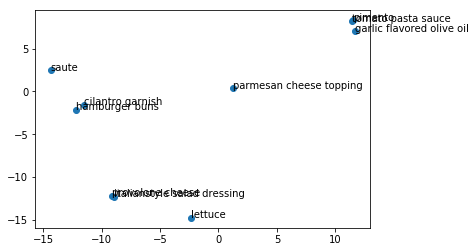

In [64]:
showTSNEGraphForWord(action_ingredients_w2v_model, df_tsne_2, pos_words=['chicken', 'rice'], neg_words=['onions']) 

# Final Dataset

In [65]:
# define the variables
EMBEDDING_SIZE = 50
MAX_LEN = 50

In [79]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_verbs['consolidated_category'])
print le.classes_

['african' 'east_asian' 'east_european' 'latin_american' 'middle_eastern'
 'north_american' 'north_european' 'south_asian' 'south_european'
 'southeast_asian']


In [174]:
df_verbs['features'] = df_verbs['combined_action_ingredients'].map(lambda x : ' , '.join(x).encode('ascii'))
df_verbs['label'] = le.transform(df_verbs['consolidated_category'])


In [175]:
features = df_verbs['features'].values
labels = df_verbs['label'].values

In [176]:
np.random.choice(features)

'skinless halibut fillets , garlic powder , salt black pepper , green onions , green bell pepper , cilantro , sour cream , mayonnaise , cheddar cheese , enchilada sauce , flour tortillas , cheddar cheese , avocados , c , prepare , f , coat , serve , cover'

In [177]:
final_X = df_verbs['features'].values
final_Y = df_verbs['label'].values

X_train, X_test, y_train, y_test = train_test_split(final_X, final_Y, test_size=0.20)

In [178]:
def print_metrics(true_y, predicted_y, target_names, y_score=None):
    """ Prints classification metrics
    Args:
        true_y: The ground truth target labels
        predicted_y: The predicted labels from the classifier
        y_score: If not None, this is vector of probability scores for positive class (used for roc_curve) (Optional)
    Returns:
        None
    """
    print classification_report(true_y, predicted_y, target_names=target_names)
    cm = confusion_matrix(true_y, predicted_y)
    print "Confusion matrix:"
    print cm
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print
    print "Confusion matrix(normalized):"
    print cm_normalized
    print
    
    print 'Overall accuracy: {}'.format(accuracy_score(true_y, predicted_y))
    print
    if y_score is not None:
        print "Area Under the ROC Curve: {}".format(roc_auc_score(true_y, y_score))
        print

# Simple Bigram Model with Random Forest

In [133]:
from sklearn.ensemble import RandomForestClassifier

In [170]:
def makePipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,2), stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(class_weight='balanced'))
    ])
    return pipeline
def trainModel(X, y):
    model = makePipeline()
    model.fit(X, y)
    return model

model = trainModel(X_train, y_train)
preds = model.predict(X_test)

In [171]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       0.50      0.03      0.06        30
     east_asian       0.60      0.70      0.64       125
  east_european       0.17      0.03      0.06        59
 latin_american       0.66      0.69      0.68       520
 middle_eastern       0.67      0.30      0.41       111
 north_american       0.46      0.69      0.55       832
 north_european       0.53      0.23      0.32       402
    south_asian       0.82      0.68      0.75       142
 south_european       0.64      0.64      0.64       555
southeast_asian       0.76      0.30      0.43       113

    avg / total       0.58      0.57      0.55      2889

Confusion matrix:
[[  1   1   0   3   2  14   1   5   3   0]
 [  0  87   1   2   0  25   5   0   3   2]
 [  0   0   2   4   0  46   6   0   1   0]
 [  0   3   0 360   1 120   8   1  23   4]
 [  0   1   2   4  33  33   4   2  32   0]
 [  0  17   1 102   4 575  39   2  89   3]
 [  0  10   4  22   3 227  93   5  37

# Embedding Layer

In [185]:
embedding_length = 100
top_words = 10000 
embedding_vecor_length = 100
tokenizer = Tokenizer(nb_words=top_words)
tokenizer.fit_on_texts(final_X)
sequences = tokenizer.texts_to_sequences(final_X)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
final_X_embedded = pad_sequences(sequences, maxlen=embedding_length)
X_train, X_test, y_train, y_test = train_test_split(final_X_embedded, final_Y, test_size=0.20)

Found 4161 unique tokens.


# RNN model with LSTM

In [187]:
def processKerasRNNModel(X, y):    
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
#     model.add(Dropout(0.5))
    model.add(LSTM(100)) #, return_sequences=True))
    model.add(Dropout(0.4))
#     model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(len(np.unique(labels)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print(model.summary())
    
    model.fit(X, y, epochs=5, batch_size=100)
    # Final evaluation of the model
    return model

In [188]:
rnn_cluster_model = processKerasRNNModel(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 1,081,410
Trainable params: 1,081,410
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
11553/11553 [==============================] - 74s - loss: 1.7924 - acc: 0.3490    
Epoch 2/5
11553/11553 [==============================] - 75s - loss: 1.2868 - acc: 0.5446    
Epoch 3/5
11553/11553 [==============================] - 69s - loss: 1.

In [191]:
preds = rnn_cluster_model.predict(X_test)

In [193]:
preds = [np.argmax(p) for p in preds]

In [194]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       0.00      0.00      0.00        28
     east_asian       0.54      0.76      0.63       135
  east_european       0.00      0.00      0.00        59
 latin_american       0.74      0.84      0.79       460
 middle_eastern       0.68      0.58      0.63       110
 north_american       0.70      0.63      0.66       946
 north_european       0.44      0.45      0.44       381
    south_asian       0.73      0.82      0.77       142
 south_european       0.69      0.80      0.74       534
southeast_asian       0.60      0.28      0.38        94

    avg / total       0.64      0.66      0.64      2889

Confusion matrix:
[[  0   3   0   0   3   2   5  13   2   0]
 [  0 103   0   1   0  17   5   2   2   5]
 [  0   1   0   1   1  15  40   0   1   0]
 [  0   0   0 386   0  45   8   8  11   2]
 [  0   3   0   5  64   9   7   3  19   0]
 [  0  21   0  92   4 599 127   4  94   5]
 [  0  11   0  18  10 102 173   4  62

/Users/chuqinghe/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# CNN Model

In [195]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.utils import to_categorical


def trainKerasModel_conv(X,Y):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(le.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print model.summary()
    model.fit(X, Y, epochs=5, batch_size=100)
    # Final evaluation of the model
    return model

conv_model = trainKerasModel_conv(X_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               49280     
__________

In [196]:
preds = conv_model.predict(X_test)

In [197]:
preds = [np.argmax(p) for p in preds]

In [198]:
print_metrics(y_test, preds, le.classes_)

                 precision    recall  f1-score   support

        african       1.00      0.04      0.07        28
     east_asian       0.72      0.56      0.63       135
  east_european       0.00      0.00      0.00        59
 latin_american       0.75      0.79      0.77       460
 middle_eastern       0.59      0.48      0.53       110
 north_american       0.61      0.73      0.66       946
 north_european       0.47      0.36      0.41       381
    south_asian       0.69      0.77      0.73       142
 south_european       0.72      0.72      0.72       534
southeast_asian       0.61      0.59      0.60        94

    avg / total       0.63      0.65      0.63      2889

Confusion matrix:
[[  1   0   0   2   5   7   0  11   1   1]
 [  0  75   0   3   0  31   7   2   1  16]
 [  0   1   0   0   1  31  26   0   0   0]
 [  0   0   0 363   2  80   3   6   6   0]
 [  0   1   0   9  53  16   3   7  20   1]
 [  0  12   0  64   4 693  85   3  73  12]
 [  0   7   0  15  12 154 137   6  47